### <span style="color:teal"> __NETWORK ANALYSIS: DISEASE UNIPARTITE GENUS NETWORK -- GENUS LEVEL__
<span style="color:teal"> In a disease-centric unipartite genus network, diseases are represented as nodes, and an edge is drawn between two diseases when they share one or more microbial genera with statistically significant associations. This network is generated as a projection from an underlying disease–genus bipartite network, where microbial genera serve as the intermediates linking diseases. Similarly, a unipartite network can also be constructed for microbial taxa, where nodes represent genera and edges indicate co-occurrence across diseases. These unipartite projections allow us to summarize complex bipartite relationships in a more intuitive form, highlighting patterns of shared dysbiosis among diseases or co-association among taxa. By focusing on disease–disease connections, the network reveals potential comorbidity patterns, identifies clusters of diseases with overlapping microbial signatures, and generates hypotheses about common pathophysiological mechanisms that may be mediated by the gut microbiome. This approach shifts the perspective from individual taxa to the broader relationships between diseases and taxa, providing a systems-level view of microbiome–host interactions.


In [1]:
# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator
import json
import pickle

# NetworkX and Seaborn
import networkx as nx
from networkx.algorithms import bipartite
print("Network X version = ",nx.__version__)

Network X version =  3.4.2


In [2]:
# LOADING GENUS DATA
df_genus = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/significant_genus_taxa.txt", sep="\t")
df_genus_network = df_genus[["disease", "ncbi_taxon_id"]].drop_duplicates()

In [3]:
# LOADING DICTIONARY DISEASE NAMES AND DISEASE CATEGORIES

# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/disease_dict.json", "r") as f:
    # Load the contents of the JSON file into a Python dictionary
    disease_dict = json.load(f)
    
# Open hte JSOn file contaiing the disease classificaiton data
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/disease_classification.json", "r") as f:
    disease_classification = json.load(f)


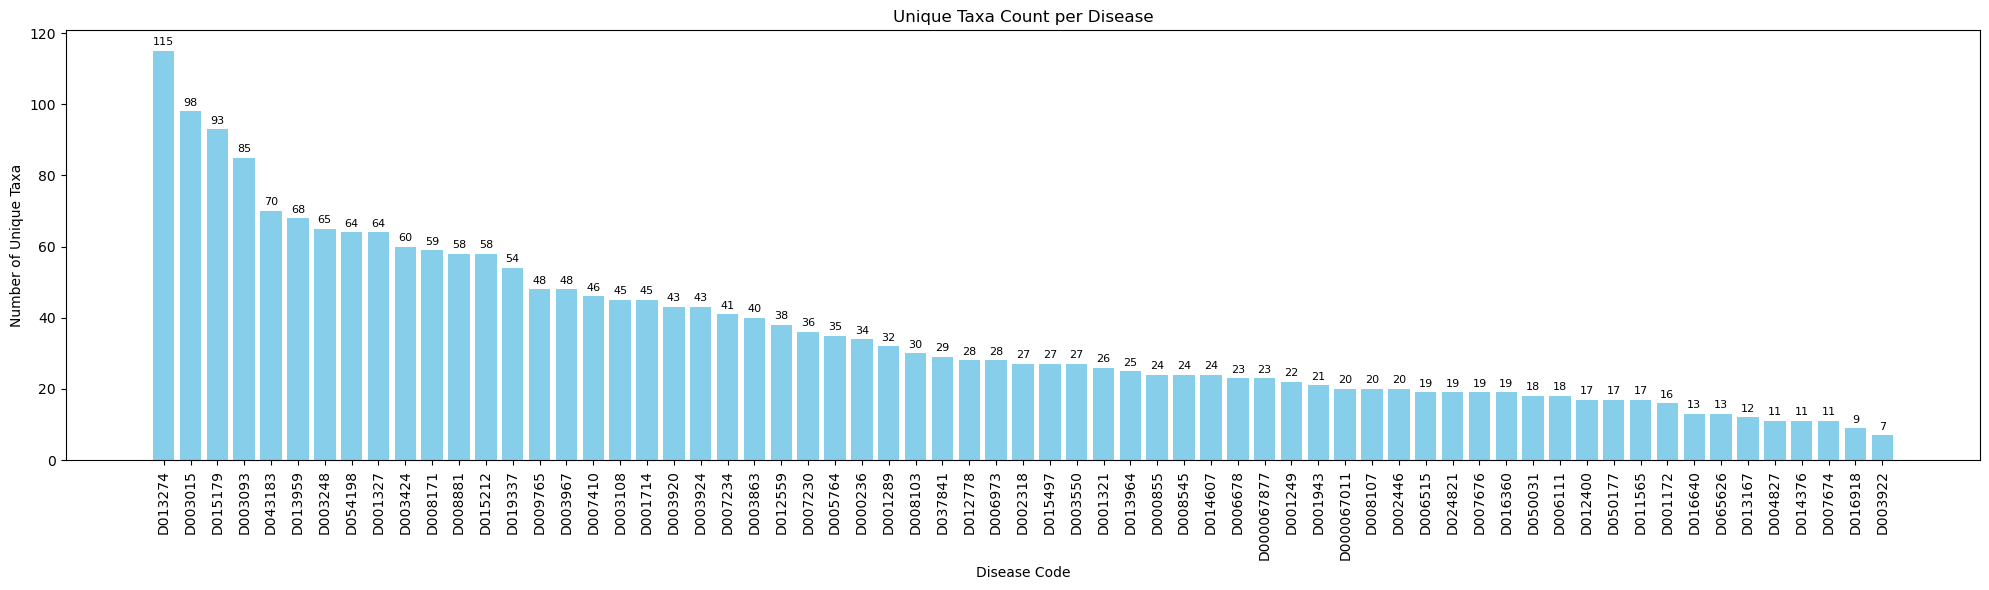

In [4]:
# Data Descritption
# Group and count unique taxa per disease
taxa_counts = (
    df_genus_network.groupby("disease")["ncbi_taxon_id"]
    .nunique()
    .reset_index(name="unique_taxa_count")
    .sort_values("unique_taxa_count", ascending=False)
)

# Plot
fig, ax = plt.subplots(figsize=(20, 6))
bars = ax.bar(taxa_counts["disease"], taxa_counts["unique_taxa_count"], color="skyblue")

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # position above the bar
        str(height),
        ha='center',
        va='bottom',
        fontsize=8
    )

# Formatting
ax.set_xlabel("Disease Code")
ax.set_ylabel("Number of Unique Taxa")
ax.set_title("Unique Taxa Count per Disease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Elbow-based ubiquity threshold: 30


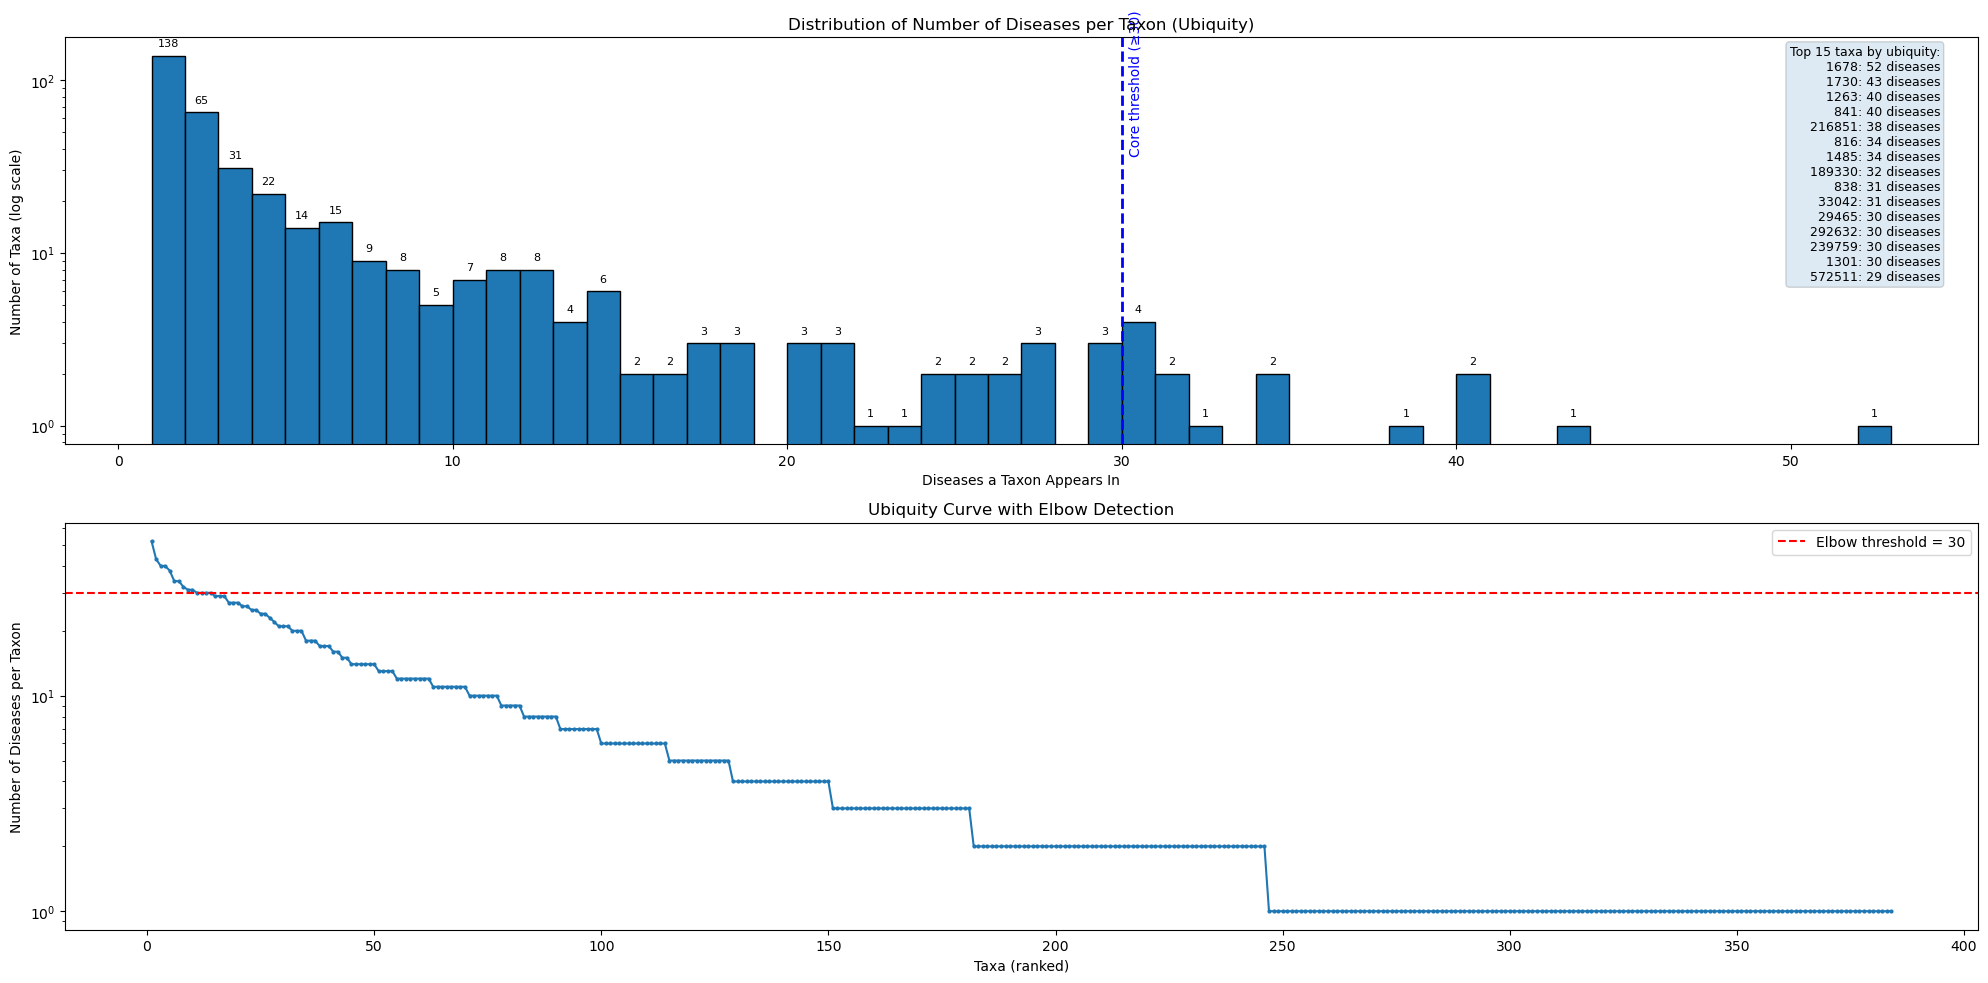

In [5]:
# UBIQUITY FILTERING TO REMOVE COMMON TAXA -- GENUS LEVEL
# --- CONFIG ---
TOP_N = 15
UBIQ_THRESHOLD = 25  # default, will be replaced by elbow if found
FIGSIZE = (20, 10)

# 1) Ensure unique (disease, taxon)
dfu = df_genus_network[["disease", "ncbi_taxon_id"]].drop_duplicates()

# 2) Calculate ubiquity (distinct diseases per taxon)
taxon_ubiquity = (
    dfu.groupby("ncbi_taxon_id")["disease"]
       .nunique()
       .sort_values(ascending=False)
       .rename("ubiquity")
)

# 3) KneeLocator to find elbow threshold
x = np.arange(1, len(taxon_ubiquity) + 1)
y = taxon_ubiquity.values
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_value = int(y[kneedle.knee - 1]) if kneedle.knee is not None else None
if elbow_value:
    UBIQ_THRESHOLD = elbow_value

print(f"Elbow-based ubiquity threshold: {UBIQ_THRESHOLD}")

# 4) Prepare figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=FIGSIZE)

# --- Subplot 1: Histogram ---
bins = np.arange(1, taxon_ubiquity.max() + 2)
counts, edges, patches = axes[0].hist(taxon_ubiquity, bins=bins, edgecolor='black')
axes[0].set_yscale("log")
axes[0].set_xlabel("Diseases a Taxon Appears In")
axes[0].set_ylabel("Number of Taxa (log scale)")
axes[0].set_title("Distribution of Number of Diseases per Taxon (Ubiquity)")

# Add labels on top of bars
for count, edge in zip(counts, edges):
    if count > 0:
        axes[0].text(edge + 0.5, count * 1.1,
                     f"{int(count)}", ha="center", va="bottom", fontsize=8)

# Threshold line
axes[0].axvline(UBIQ_THRESHOLD, linestyle="--", linewidth=2, color='blue')
axes[0].text(UBIQ_THRESHOLD + 0.2, max(counts[counts > 0]) * 0.7,
             f"Core threshold (≥{UBIQ_THRESHOLD})",
             rotation=90, va="center", color='blue')

# Top taxa annotation
top_rows = taxon_ubiquity.head(TOP_N)
top_text = "\n".join([f"{int(tid)}: {ub} diseases" for tid, ub in top_rows.items()])
props = dict(boxstyle="round", alpha=0.15)
axes[0].text(0.98, 0.98, f"Top {TOP_N} taxa by ubiquity:\n{top_text}",
             transform=axes[0].transAxes, ha="right", va="top", bbox=props, fontsize=9)

# --- Subplot 2: Ubiquity rank curve ---
axes[1].plot(x, y, marker='o', markersize=2)
if elbow_value:
    axes[1].axhline(elbow_value, color='red', linestyle='--',
                    label=f"Elbow threshold = {elbow_value}")
axes[1].set_yscale("log")
axes[1].set_xlabel("Taxa (ranked)")
axes[1].set_ylabel("Number of Diseases per Taxon")
axes[1].set_title("Ubiquity Curve with Elbow Detection")
axes[1].legend()

# --- Show only ---
plt.tight_layout()
plt.show()


In [6]:
# POST UBIQUITY FILTERING SUMMARY
# 1) Ensure unique (disease, taxon) pairs
dfu = df_genus_network[["disease", "ncbi_taxon_id"]].drop_duplicates()

# 2) Calculate ubiquity (number of distinct diseases per taxon)
taxon_ubiquity = (
    dfu.groupby("ncbi_taxon_id")["disease"]
       .nunique()
       .sort_values(ascending=False)
       .rename("ubiquity")
)

# 3) Find elbow threshold
x = np.arange(1, len(taxon_ubiquity) + 1)
y = taxon_ubiquity.values
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_value = int(y[kneedle.knee - 1]) if kneedle.knee is not None else None


# 4) Remove high-ubiquity taxa (keep only those BELOW threshold)
if elbow_value:
    low_ubiquity_taxa = taxon_ubiquity[taxon_ubiquity < elbow_value].index
    df_genus_network_filtered = df_genus_network[df_genus_network["ncbi_taxon_id"].isin(low_ubiquity_taxa)]
else:
    df_genus_network_filtered = df_genus_network.copy()


# =====================================================
# 5) Detailed Filtering Summary
# =====================================================
total_taxa = df_genus_network["ncbi_taxon_id"].nunique()
filtered_taxa = df_genus_network_filtered["ncbi_taxon_id"].nunique()
removed_taxa = total_taxa - filtered_taxa

total_diseases = df_genus_network["disease"].nunique()
diseases_after = df_genus_network_filtered["disease"].nunique()

avg_ubiq_after = (
    dfu[dfu["ncbi_taxon_id"].isin(df_genus_network_filtered["ncbi_taxon_id"])]
    .groupby("ncbi_taxon_id")["disease"]
    .nunique()
    .mean()
)

print("\n=== Ubiquity Filtering Summary ===")
print(f"Ubiquity threshold applied: {elbow_value if elbow_value else 'None'}")
print(f"Original total rows: {len(df_genus_network):,}")
print(f"Remaining rows after filtering: {len(df_genus_network_filtered):,}")
print(f"Original number of unique taxa: {total_taxa:,}")
print(f"Number of unique taxa removed: {removed_taxa:,} ({removed_taxa/total_taxa:.1%} of taxa)")
print(f"Number of unique taxa kept: {filtered_taxa:,}")
print(f"Original number of diseases: {total_diseases:,}")
print(f"Diseases retained after filtering: {diseases_after:,} ({diseases_after/total_diseases:.1%} of diseases still connected)")
print(f"Average ubiquity (before): {taxon_ubiquity.mean():.2f} diseases/taxon")
print(f"Average ubiquity (after): {avg_ubiq_after:.2f} diseases/taxon")

# Show top 5 most ubiquitous taxa removed
if elbow_value:
    removed_taxa_ids = taxon_ubiquity[taxon_ubiquity >= elbow_value].head(5)
    print("\nTop 5 most ubiquitous taxa removed:")
    for tid, ubiq in removed_taxa_ids.items():
        print(f"  Taxon {tid}: {ubiq} diseases")




=== Ubiquity Filtering Summary ===
Ubiquity threshold applied: 30
Original total rows: 2,319
Remaining rows after filtering: 1,824
Original number of unique taxa: 384
Number of unique taxa removed: 14 (3.6% of taxa)
Number of unique taxa kept: 370
Original number of diseases: 65
Diseases retained after filtering: 65 (100.0% of diseases still connected)
Average ubiquity (before): 6.04 diseases/taxon
Average ubiquity (after): 4.93 diseases/taxon

Top 5 most ubiquitous taxa removed:
  Taxon 1678: 52 diseases
  Taxon 1730: 43 diseases
  Taxon 1263: 40 diseases
  Taxon 841: 40 diseases
  Taxon 216851: 38 diseases


### <span style="color:teal"> __BIPARTITE DISEASE-TAXON NETWORK CONSTRUCTION__


Bipartite Disease–Taxa Network Summary
--------------------------------------
Nodes: 435  |  Edges: 1824
  • Diseases (U): 65
  • Taxa     (V): 370

Edge density (E / U×V): 0.075842  (range: 0 = no edges, 1 = fully connected)

Degree stats — Diseases (neighbors per disease)
  mean: 28.062  |  median: 20.000
  min:  3   |  max:    106
  std:  21.216   |  IQR:    23.000
  Q25:  14.000   |  Q75:    37.000

Degree stats — Taxa (neighbors per taxon)
  mean: 4.930     |  median: 2.000
  min:  1      |  max:    29
  std:  6.098      |  IQR:    5.000
  Q25:  1.000      |  Q75:    6.000



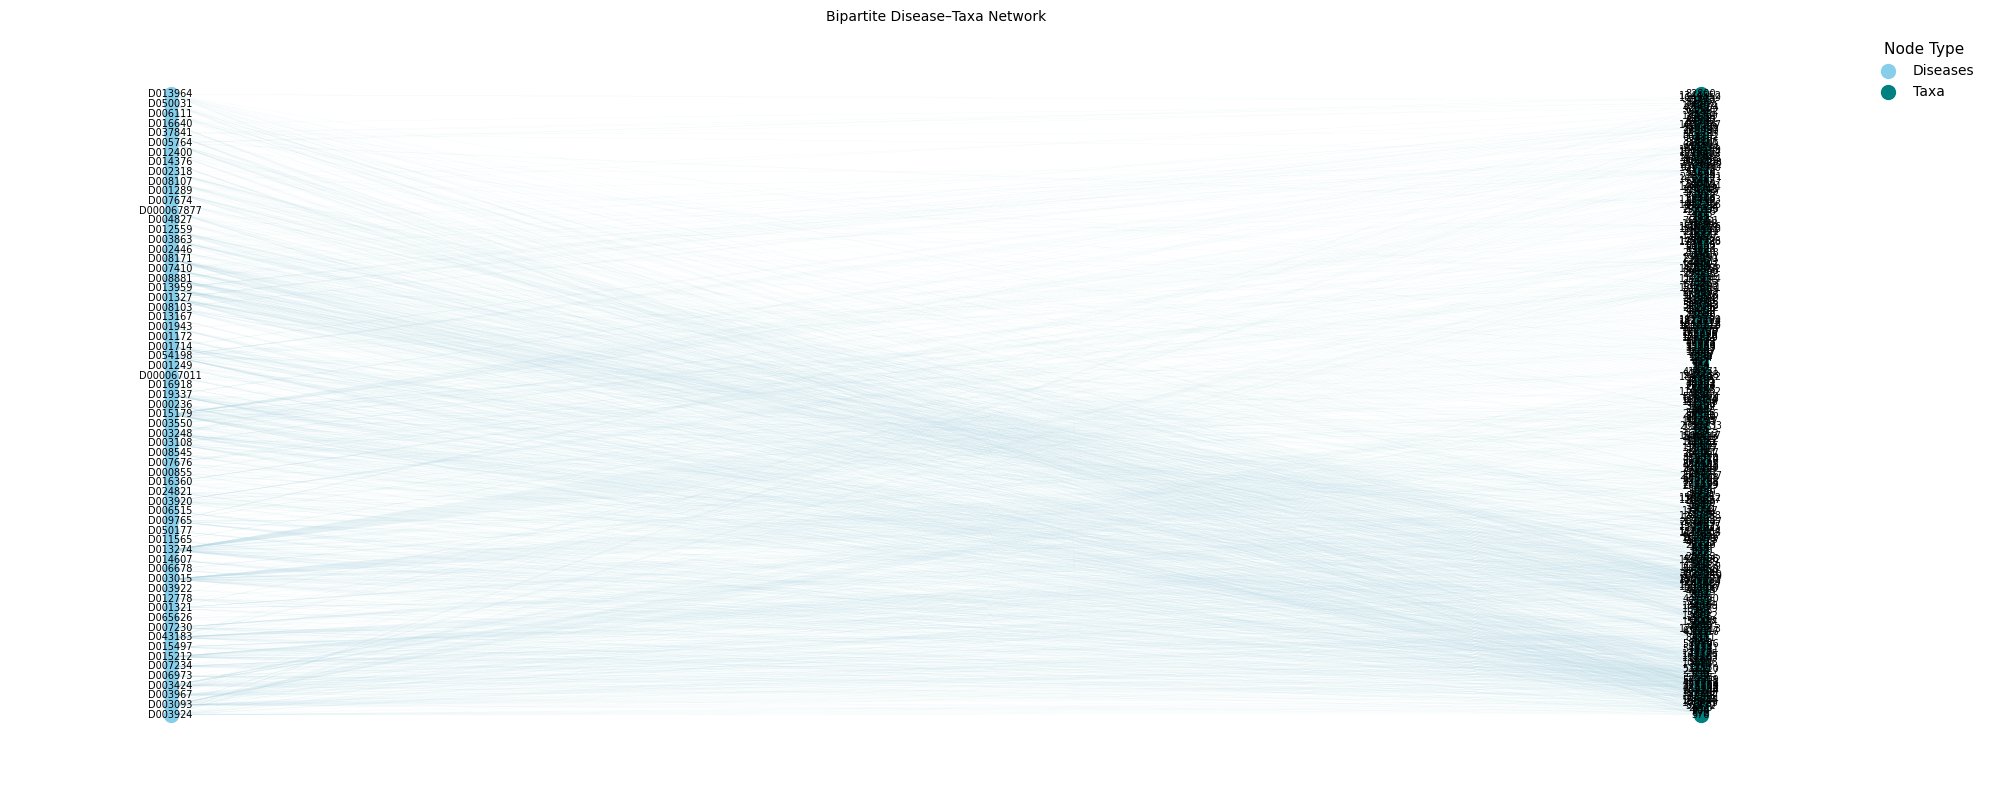

In [7]:
# === Build bipartite ===
B = nx.Graph()

# unique nodes for each layer
diseases = df_genus_network_filtered['disease'].unique()
taxa = df_genus_network_filtered['ncbi_taxon_id'].astype(str).unique()

# add nodes with bipartite attribute
B.add_nodes_from(diseases, bipartite=0)  # layer 0 = diseases
B.add_nodes_from(taxa, bipartite=1)      # layer 1 = taxa

# add edges
edges = df_genus_network_filtered[['disease', 'ncbi_taxon_id']].drop_duplicates()
edges['ncbi_taxon_id'] = edges['ncbi_taxon_id'].astype(str)
B.add_edges_from(edges.values.tolist())

# === Separate nodes ===
disease_nodes = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 0]
taxa_nodes    = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 1]

# === Density (bipartite) ===
E = B.number_of_edges()
U = len(disease_nodes)
V = len(taxa_nodes)
max_possible_edges = U * V
density = E / max_possible_edges if max_possible_edges > 0 else float('nan')

# === Degree stats helper ===
def degree_stats(G, nodes):
    deg = np.array([G.degree(n) for n in nodes], dtype=float)
    if deg.size == 0:
        return dict(mean=np.nan, median=np.nan, min=np.nan, max=np.nan,
                    std=np.nan, q25=np.nan, q75=np.nan, iqr=np.nan)
    return dict(
        mean   = float(deg.mean()),
        median = float(np.median(deg)),
        min    = float(deg.min()),
        max    = float(deg.max()),
        std    = float(deg.std(ddof=0)),
        q25    = float(np.percentile(deg, 25)),
        q75    = float(np.percentile(deg, 75)),
        iqr    = float(np.percentile(deg, 75) - np.percentile(deg, 25)),
    )

disease_deg = degree_stats(B, disease_nodes)
taxa_deg    = degree_stats(B, taxa_nodes)

# === Descriptive summary ===
print(f"""
Bipartite Disease–Taxa Network Summary
--------------------------------------
Nodes: {B.number_of_nodes()}  |  Edges: {E}
  • Diseases (U): {U}
  • Taxa     (V): {V}

Edge density (E / U×V): {density:.6f}  (range: 0 = no edges, 1 = fully connected)

Degree stats — Diseases (neighbors per disease)
  mean: {disease_deg['mean']:.3f}  |  median: {disease_deg['median']:.3f}
  min:  {disease_deg['min']:.0f}   |  max:    {disease_deg['max']:.0f}
  std:  {disease_deg['std']:.3f}   |  IQR:    {disease_deg['iqr']:.3f}
  Q25:  {disease_deg['q25']:.3f}   |  Q75:    {disease_deg['q75']:.3f}

Degree stats — Taxa (neighbors per taxon)
  mean: {taxa_deg['mean']:.3f}     |  median: {taxa_deg['median']:.3f}
  min:  {taxa_deg['min']:.0f}      |  max:    {taxa_deg['max']:.0f}
  std:  {taxa_deg['std']:.3f}      |  IQR:    {taxa_deg['iqr']:.3f}
  Q25:  {taxa_deg['q25']:.3f}      |  Q75:    {taxa_deg['q75']:.3f}
""")

# === Plot ===
pos = nx.bipartite_layout(B, disease_nodes)

plt.figure(figsize=(20, 8))
nx.draw_networkx_nodes(B, pos, nodelist=disease_nodes, node_color="skyblue", node_size=100, label="Diseases")
nx.draw_networkx_nodes(B, pos, nodelist=taxa_nodes, node_color="teal",     node_size=100, label="Taxa")
nx.draw_networkx_edges(B, pos, alpha=0.35, width=0.1, edge_color='lightblue')
nx.draw_networkx_labels(B, pos, font_size=7)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=10,
           title="Node Type", title_fontsize=11)
plt.axis("off")
plt.title("Bipartite Disease–Taxa Network", fontsize=10)
plt.tight_layout()
plt.show()


### <span style="color:teal"> __UNIPARTITE PROJECTION__
<span style="color:white"> __1. DISEASE-DISEASE PROJECTION__
<span style="color:white"> __2. TAXON-TAXON PROJECTION__


Disease–Disease Unipartite Summary:
- Nodes: 65
- Edges: 1914
- Density: 0.9202
- Degree: mean 58.89, median 61.00, min 36, max 64


Taxa–Taxa Unipartite Summary:
- Nodes: 370
- Edges: 22553
- Density: 0.3304
- Degree: mean 121.91, median 105.00, min 14, max 316



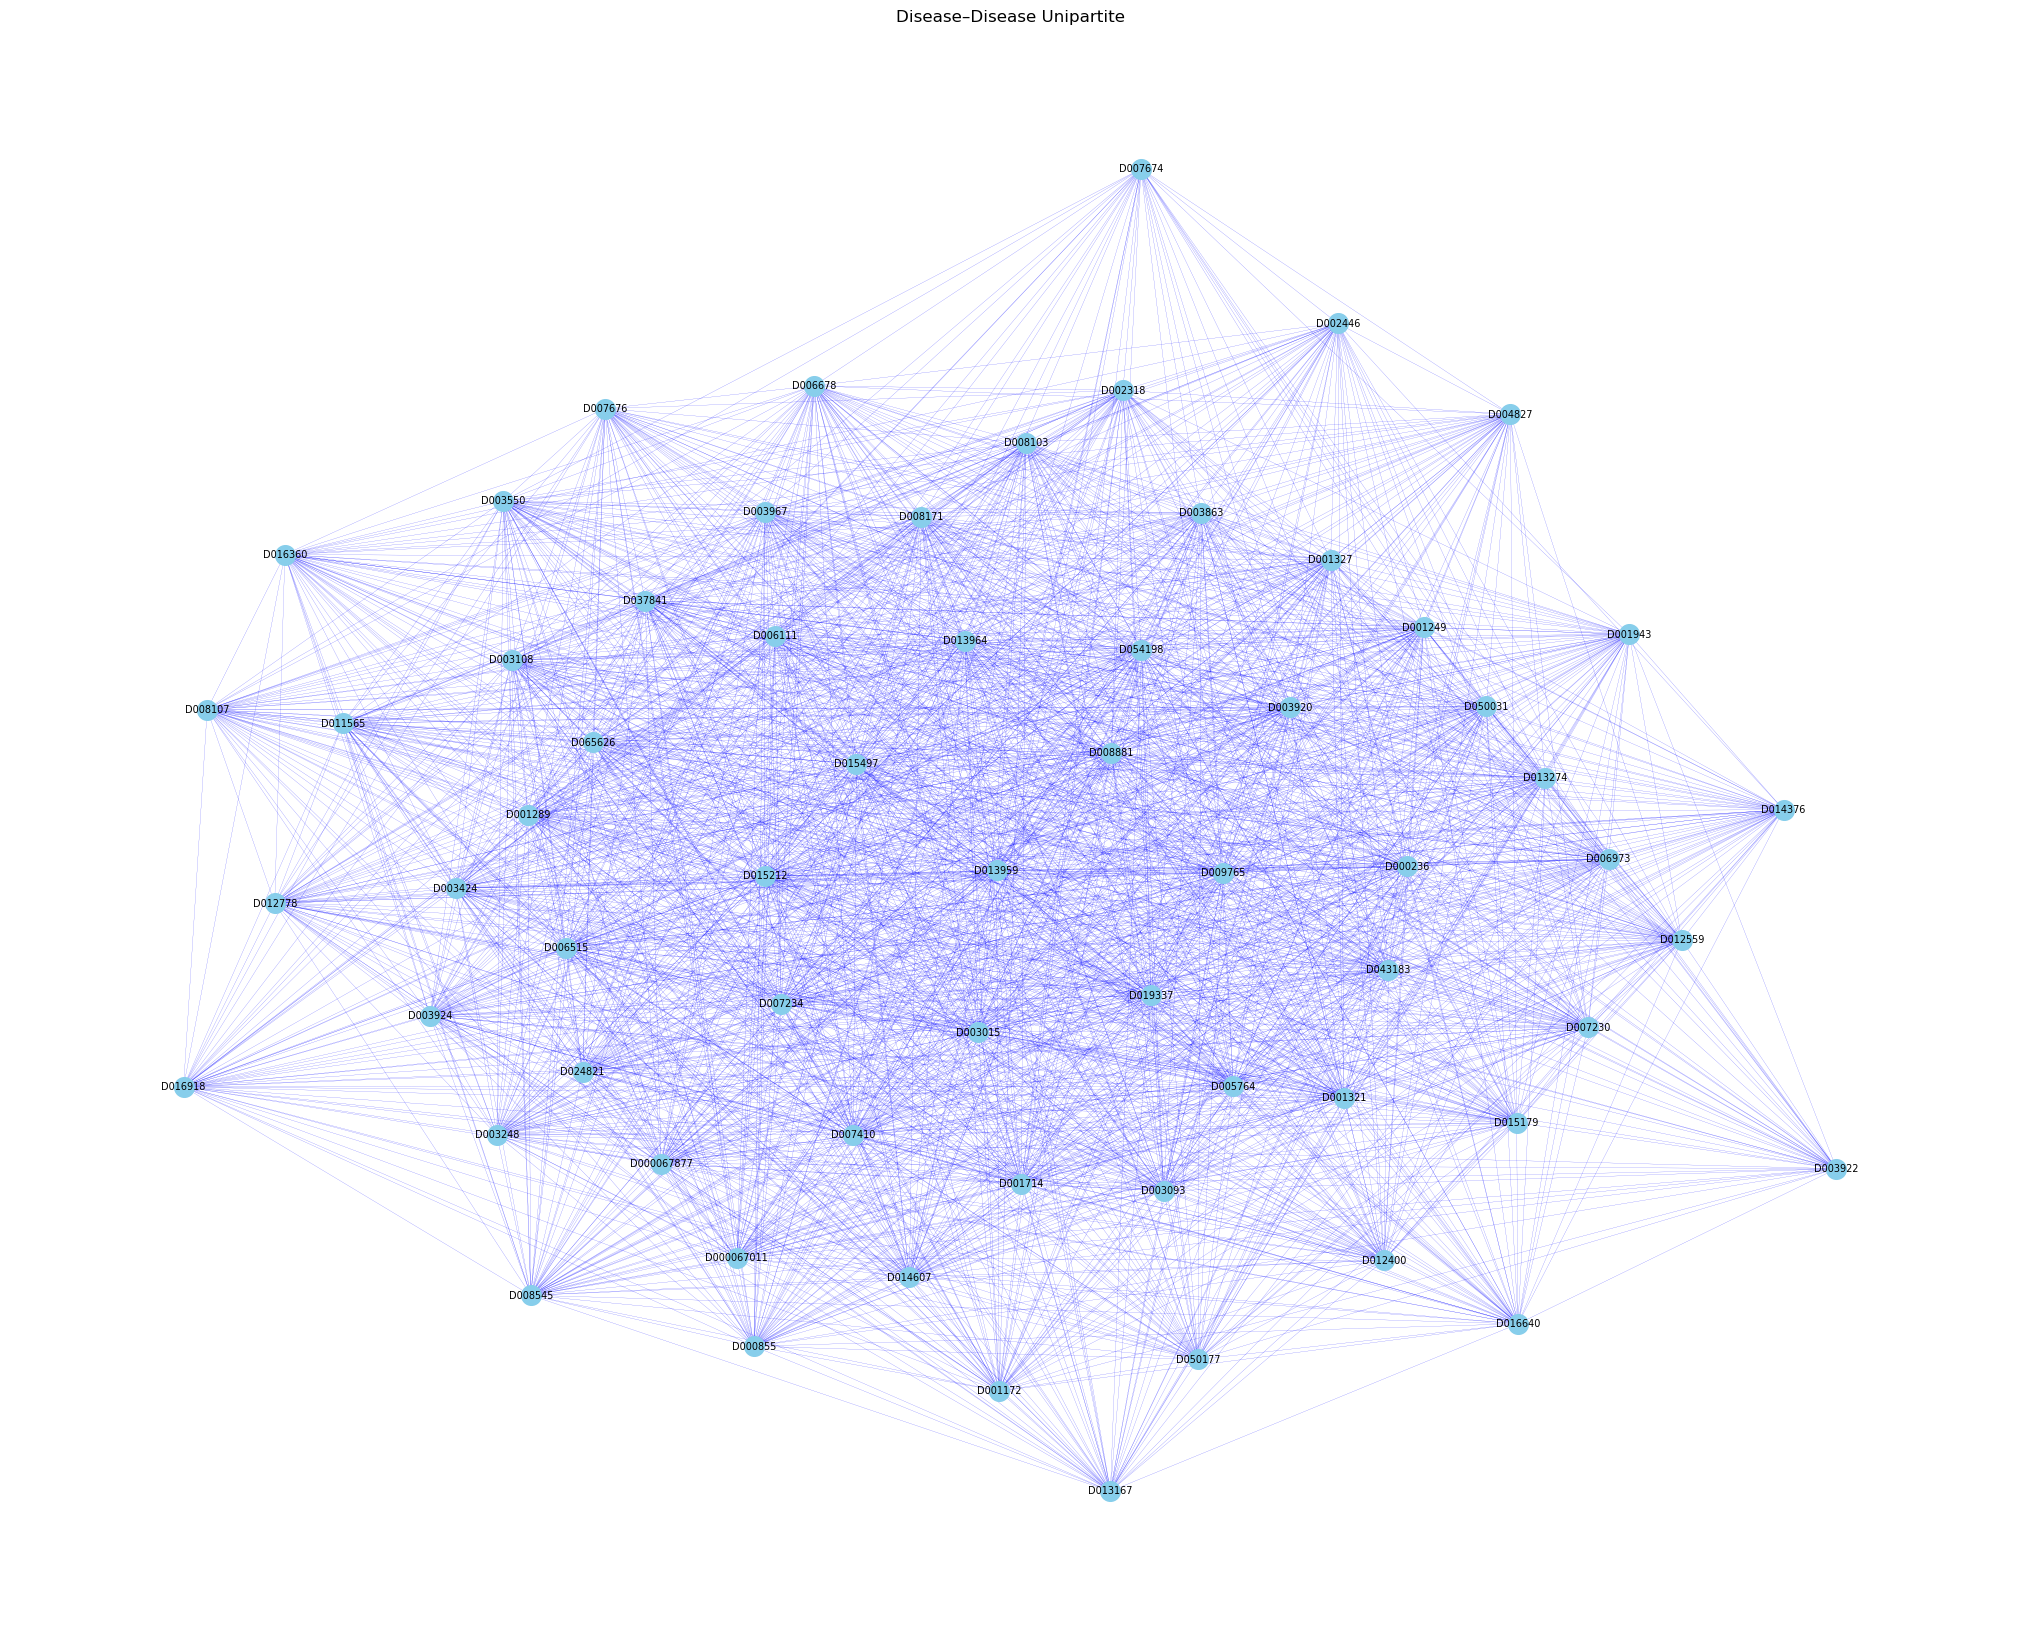

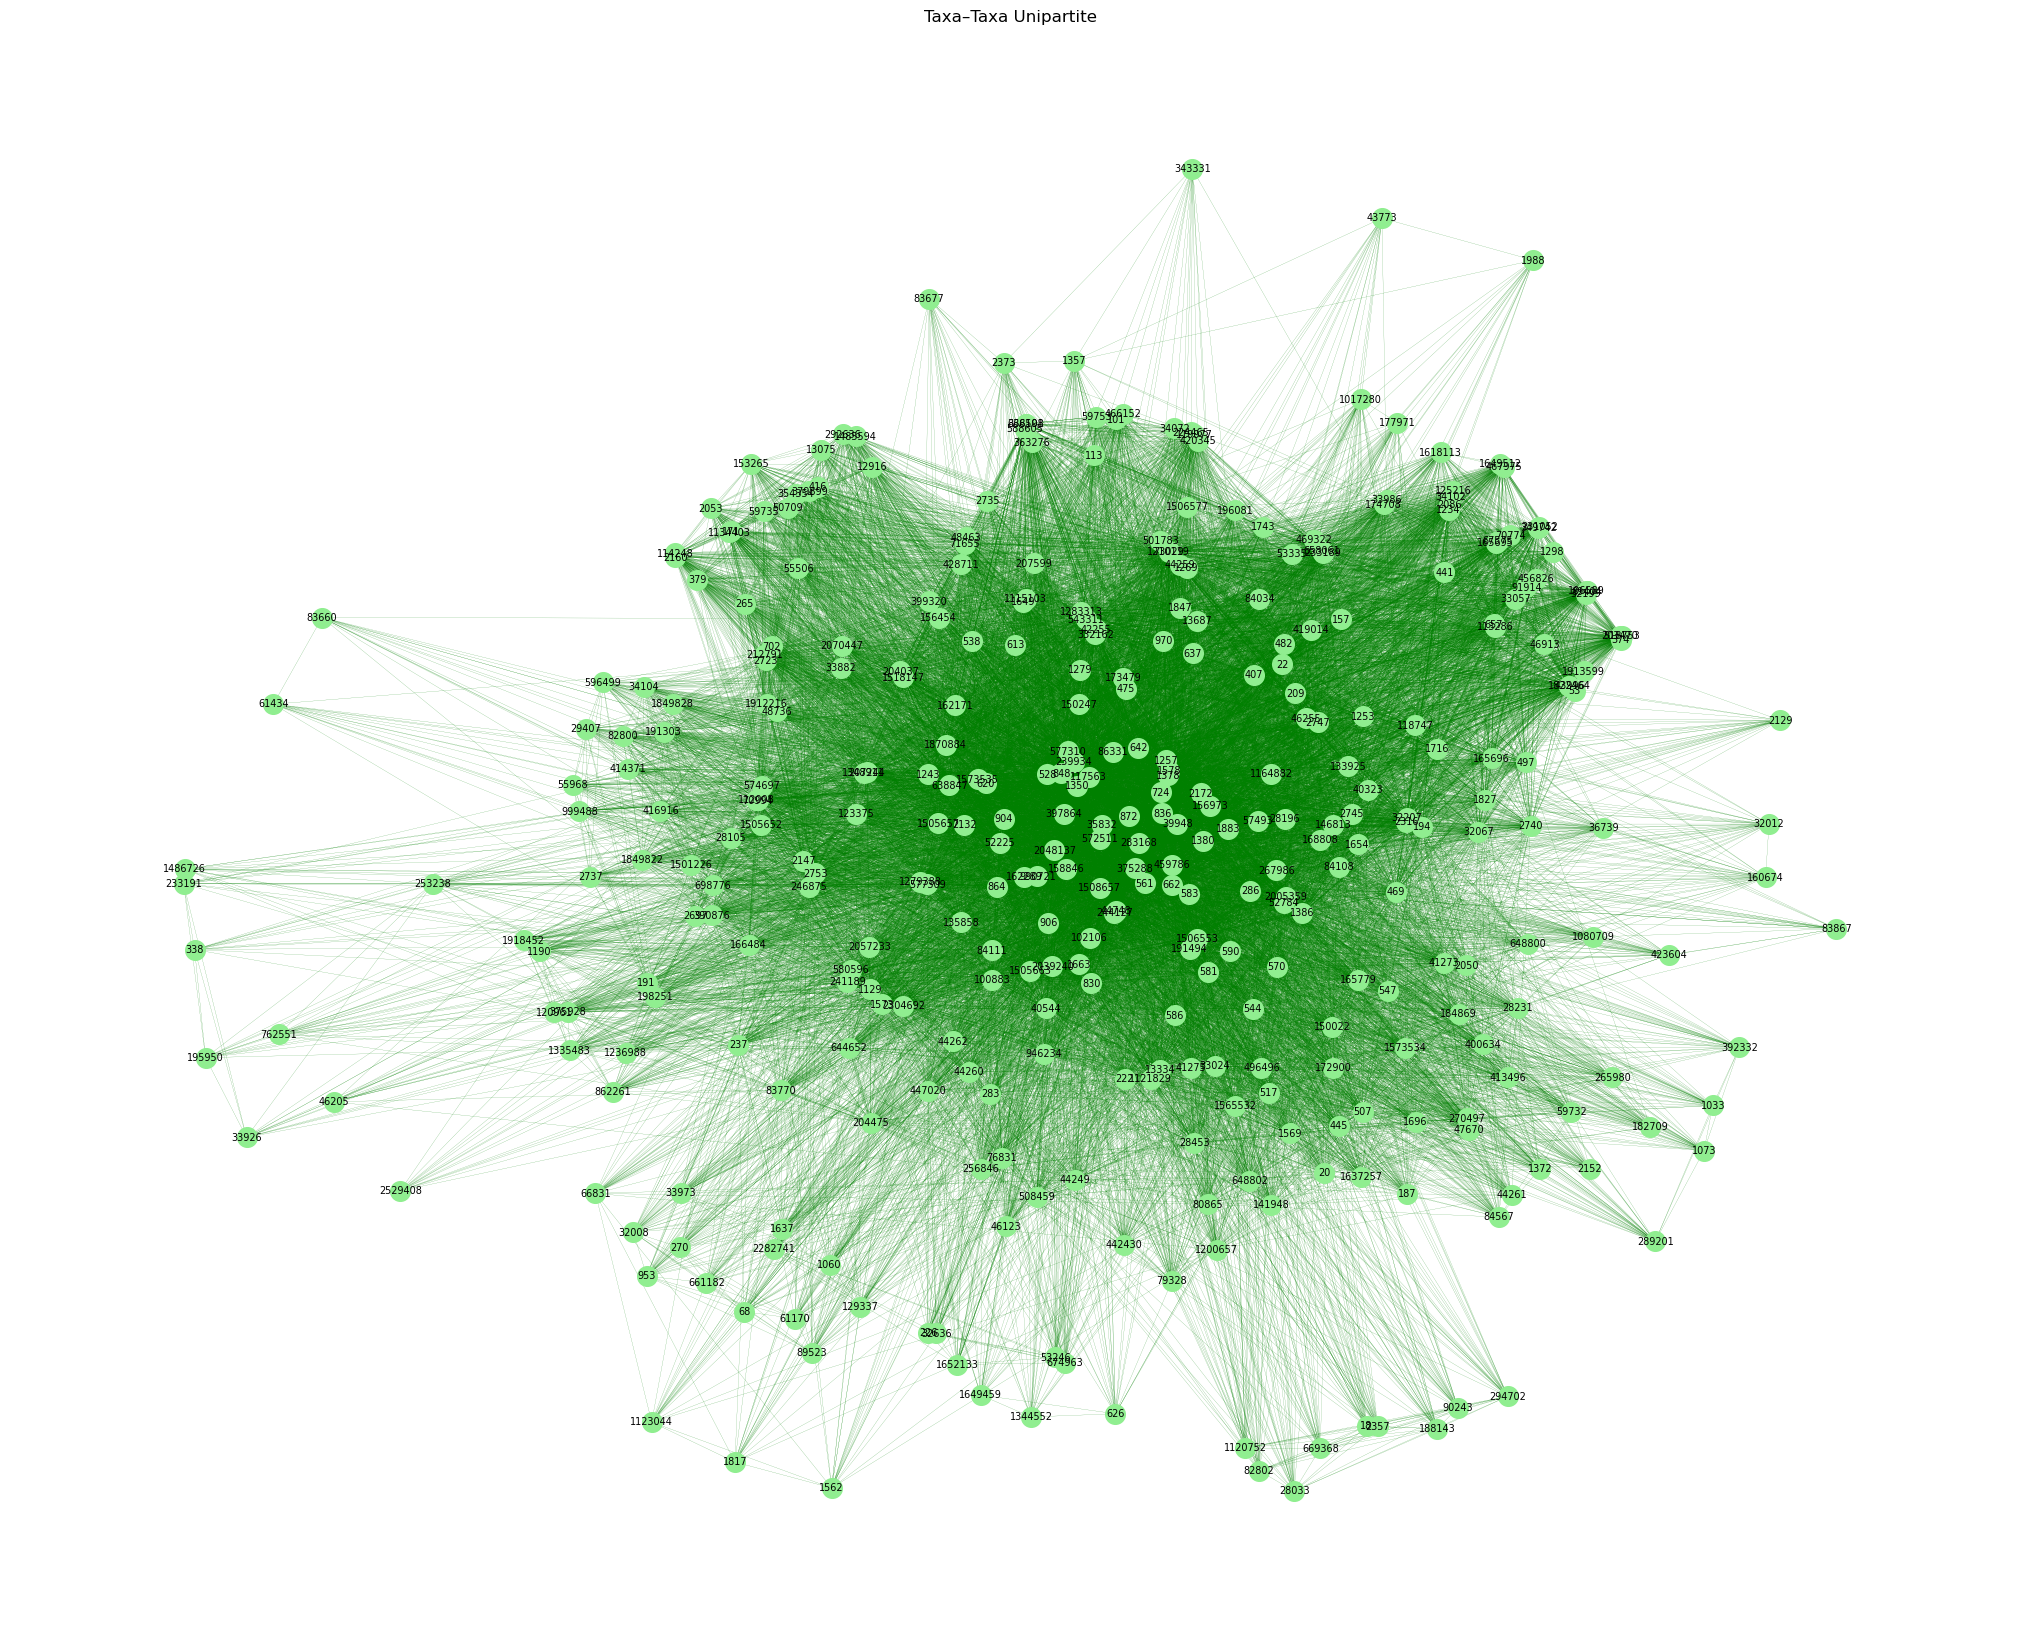

In [8]:
# Separate the two node sets from B
disease_nodes = [n for n, d in B.nodes(data=True) if d["bipartite"] == 0]
taxa_nodes    = [n for n, d in B.nodes(data=True) if d["bipartite"] == 1]

# Simple unipartite projections
G_disease = bipartite.projected_graph(B, disease_nodes)
G_taxa    = bipartite.projected_graph(B, taxa_nodes)

def describe_graph(G, name):
    n = G.number_of_nodes()
    e = G.number_of_edges()
    max_possible_edges = n * (n - 1) / 2
    density = e / max_possible_edges if max_possible_edges else 0
    deg = np.array([G.degree(n) for n in G.nodes()])
    print(f"""
{name} Summary:
- Nodes: {n}
- Edges: {e}
- Density: {density:.4f}
- Degree: mean {deg.mean():.2f}, median {np.median(deg):.2f}, min {deg.min()}, max {deg.max()}
""")

# Print summaries
describe_graph(G_disease, "Disease–Disease Unipartite")
describe_graph(G_taxa, "Taxa–Taxa Unipartite")

# Plot Disease–Disease
plt.figure(figsize=(20, 16))
nx.draw(G_disease, with_labels=True, node_color="skyblue",
        node_size=200, font_size=7, width=0.1, edge_color='blue')
plt.title("Disease–Disease Unipartite")
plt.axis("off")
plt.show()

# Plot Taxa–Taxa
plt.figure(figsize=(20, 16))
nx.draw(G_taxa, with_labels=True, node_color="lightgreen",
        node_size=200, font_size=7, width=0.1, edge_color='green')
plt.title("Taxa–Taxa Unipartite")
plt.axis("off")
plt.show()


# Save bipartite
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/bipartite_genus_network.gpickle", "wb") as f:
    pickle.dump(B, f)

# Save unipartite (disease)
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/unipartite_disease_genus.gpickle", "wb") as f:
    pickle.dump(G_disease, f)

# Save unipartite (taxa)
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/unipartite_taxa_genus.gpickle", "wb") as f:
    pickle.dump(G_taxa, f)
